# Figure 6 and S6

This notebook contains code for reproducing results from figures 6 and S6 in Yang\*, Jones\* et al _bioRxiv_ 2021.

In [208]:
import os

from bokeh import palettes
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy 
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

In [5]:
adata = sc.read_h5ad("/data/yosef2/users/mattjones/projects/kptc/KPTracer-Data/expression/adata_processed.combined.h5ad")

## Display annotations on transcriptional space

Note that this expression data is an integrated result combining three genetic KO models of KP tumor progression (KP, KPL and KPA). We performed batch correction and label transfer with `scVI` and `scanVI`, respectively with the [scvi-tools](https://scvi-tools.org/) package. These analyses will not be performed below because of the stochasticity in model fitting and the manual iterations needed to find new transcriptional clusters.

Also note that for the purposes of visualization in the manuscript, we rotated UMAP projections by 180 degrees to more closely match the orientation of the trajectory reported in Figure 3A.

### Figure 6A-B

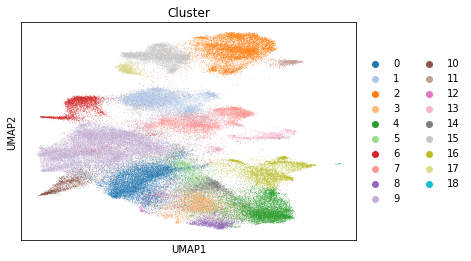

In [13]:
# reset colors to match manuscript
clust_colors = palettes.Category20[20]
clust_colors += palettes.Spectral[3][:len(adata.uns['Cluster_colors'])-20]
adata.uns['Cluster_colors'] = clust_colors

sc.pl.umap(adata, color = 'Cluster')

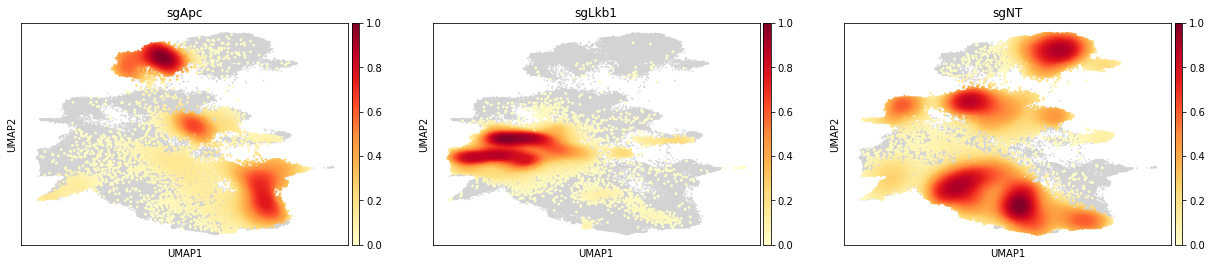

In [18]:
sc.tl.embedding_density(adata, basis='umap', groupby='genotype')
sc.pl.embedding_density(adata, basis='umap', groupby='genotype', bg_dotsize=10, fg_dotsize=30)


### Figure 6C

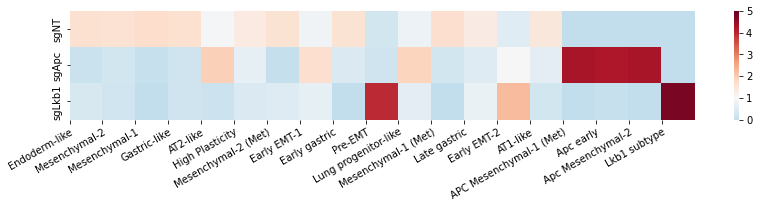

In [37]:
def enrichment_test(dataset, cluster, group='genotype'):
    
    # cdf(k, M, n, N)
    # k = overlap
    # M = total number of cells
    # n = number of type I cells (i.e., cells in a cluster overall)
    # N = number of draws (i.e., number of cells in a given perturbation/group)
    
    piv = dataset.obs.groupby(by = ['Cluster', group]).size().unstack()
    
    group_to_stats = {}
    group_to_pvalue = {}
    
    for grp in dataset.obs[group].unique():
        
        overlap_size = piv.loc[cluster, grp]
        pop_size = piv.sum().sum()
        sample_size = piv.loc[:,grp].sum()
        cluster_size = piv.loc[cluster,:].sum()
        
        group_to_stats[grp] = (overlap_size*pop_size) / (sample_size * cluster_size)
        group_to_pvalue[grp] = scipy.stats.hypergeom.sf(overlap_size - 1, pop_size, cluster_size, sample_size)
        
    return group_to_stats, group_to_pvalue

cluster_to_enrichments = {}
cluster_to_significance = {}

cluster_to_statistic = {}

for cluster in adata.obs['Cluster'].unique():
    
    enrichments, significances = enrichment_test(adata, cluster)
    cluster_to_statistic[int(cluster)] = {}
    for genotype in enrichments.keys():
        cluster_to_statistic[int(cluster)][genotype] = enrichments[genotype]

cluster_to_statistic = pd.DataFrame.from_dict(cluster_to_statistic)
cluster_to_statistic = cluster_to_statistic.loc[:,np.sort(cluster_to_statistic.columns)]

matplotlib.rcParams.update({'font.size': 10})
fig = plt.figure(figsize = (14, 2))
ax = plt.gca()
sns.heatmap(cluster_to_statistic, cmap='RdBu_r', ax=ax, center=1.0, vmax=5)
plt.xticks(range(19), ['Endoderm-like', 'Mesenchymal-2', 'Mesenchymal-1', 'Gastric-like', 'AT2-like', 'High Plasticity', 'Mesenchymal-2 (Met)',
            'Early EMT-1', 'Early gastric', 'Pre-EMT', 'Lung progenitor-like', 'Mesenchymal-1 (Met)', 'Late gastric', 'Early EMT-2',
            'AT1-like', 'APC Mesenchymal-1 (Met)', 'Apc early', 'Apc Mesenchymal-2', 'Lkb1 subtype'], rotation=30, rotation_mode='anchor', ha='right')
plt.show()

### Plot gene markers for KPA clusters - Figure S6D

In [76]:
adata_raw = adata.raw.to_adata()

adata_raw.layers['logged'] = adata_raw.X.copy()

scale_factor = np.median(np.array(adata_raw.X.sum(axis=1)))
sc.pp.normalize_total(adata_raw, target_sum=scale_factor, layers=['logged'])

adata_raw.layers['counts'] = adata_raw.layers['logged'].copy()

adata_raw.layers['scaled'] = sc.pp.scale(adata_raw, copy=True, layer='counts').X


sc.pp.log1p(adata_raw, layer='logged')


/home/eecs/mattjones/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


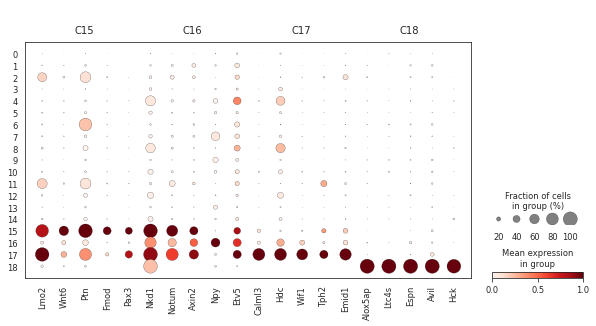

In [77]:
markers = {
            'C15': ['Lmo2', 'Wnt6', 'Ptn', 'Fmod', 'Pax3'],
            'C16': ['Nkd1', 'Notum', 'Axin2', 'Npy', 'Etv5'],
            'C17': ['Calml3', 'Hdc', 'Wif1', 'Tph2', 'Emid1'],
            'C18': ['Alox5ap', 'Ltc4s', 'Espn', 'Avil', 'Hck']
          }

h = plt.figure(figsize=(10, 5))
ax = plt.gca()
sc.pl.dotplot(adata_raw, var_names = markers, layer='scaled', groupby='Cluster', standard_scale='var', ax=ax, dot_max=1.0, show=False)
plt.show()

### Evaluate DE of Pre-EMT cluster in KPL tumors - Figure 6E

This DE test was performed in Scanpy using the `t-test` method. We read in the DE results and plot the volcano plot below.

/home/eecs/mattjones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


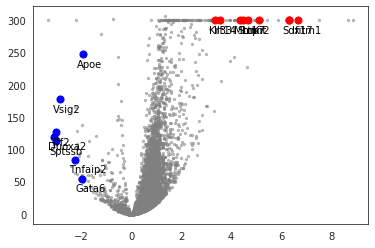

In [86]:
de_res = pd.read_csv('/data/yosef2/users/mattjones/projects/kptc/KPTracer-Data/expression/all_de_results.cluster9.tsv', sep='\t')
columns = [f'genotypesgLkb1_' + group for group in ["names", "logfoldchanges", "pvals_adj", "percent_expressed"]]

de_res_sub = de_res[columns]
de_res_sub.set_index(f'genotypesgLkb1_names', inplace=True)

up_highlighted_genes = ['Ltf', 'Mmp7', 'Sox17', 'Il33', 'Krt14', 'Kit', 'Ifitm1', 'Stmn2', 'Sox17']

down_highlighted_genes = ['Duoxa2', 'Sptssb', 'Tff2', 'Vsig2', 'Tnfaip2', 'Gata6', 'Apoe']
bg_genes = np.setdiff1d(de_res_sub.index.values, np.union1d(up_highlighted_genes, down_highlighted_genes))

de_res_sub['log10qval'] = -np.log10(de_res_sub[f'genotypesgLkb1_pvals_adj'])
de_res_sub.loc[np.isinf(de_res_sub['log10qval']), 'log10qval'] = 300
plt.scatter(de_res_sub.loc[bg_genes, f'genotypesgLkb1_logfoldchanges'], de_res_sub.loc[bg_genes, 'log10qval'], color='gray', s=5, alpha=0.5)
plt.scatter(de_res_sub.loc[up_highlighted_genes, f'genotypesgLkb1_logfoldchanges'], de_res_sub.loc[up_highlighted_genes, 'log10qval'], color='red', s=50)
plt.scatter(de_res_sub.loc[down_highlighted_genes, f'genotypesgLkb1_logfoldchanges'], de_res_sub.loc[down_highlighted_genes, 'log10qval'], color='blue', s=50)

for gene in np.union1d(up_highlighted_genes, down_highlighted_genes):
        
    coord = (de_res_sub.loc[gene, f'genotypesgLkb1_logfoldchanges'] - 0.25, de_res_sub.loc[gene, 'log10qval']-20)
    plt.annotate(gene, coord, color='black')

plt.show()

### Evalute expansions on KPL and KPA tumors - Figure S6A, B

In [110]:
NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2

tumor_clone_statistics = pd.read_csv("../../data/tumor_statistics.tsv", sep='\t', index_col = 0)
tumor2model = pd.read_csv("../../../trees/tumor_model.txt", sep='\t', index_col = 0)
trcr_master = pd.read_csv("../../data/trcr_master.txt", sep='\t')


filtered = tumor_clone_statistics[(tumor_clone_statistics['NumCells'] < NUM_CELLS_THRESH) | 
                                  (tumor_clone_statistics['PercentUnique'] <= PERCENT_UNIQUE_THRESH) |
                                 (tumor_clone_statistics['PercentUnsaturatedTargets'] <= PERCENT_UNSATURATED_TARGETS_THRESH)].index

In [232]:
tumors = tumor2model.index
total_expansion_df_nj = pd.DataFrame(columns = ['Tumor', 'ExpandingNode', 'SubProp', 'TotalProp'])
total_expansion_df_cas = pd.DataFrame(columns = ['Tumor', 'ExpandingNode', 'SubProp', 'TotalProp'])
i = 0
j = 0

for tumor in tumors:
    exp_fp_cas = f'/data/yosef2/users/mattjones/projects/kptc/trees/{tumor}/clonal_expansions.{tumor}.txt'
    
    if 'Fam' in tumor or 'Mets' in tumor or tumor in filtered or 'All' in tumor:
        continue
        
    if not os.path.exists(exp_fp_cas):
        continue
    
    if '3467' in tumor:
        continue
    
    exp_df_cas = pd.read_csv(exp_fp_cas, sep='\t', index_col = 0)
    
    if exp_df_cas.shape[0] == 0:
        total_expansion_df_cas.loc[j] = [tumor, None, 0.0, 0.0]
        j += 1
    

    for ind, row in exp_df_cas.iterrows():
        total_expansion_df_cas.loc[j] =  [tumor, ind, row.SubProp, row.TotalProp]
        j += 1     

In [233]:
total_expansion_df_cas['genotype'] = total_expansion_df_cas.apply(lambda x: x.Tumor.split("_")[1], axis=1)
prop_df = total_expansion_df_cas[['Tumor', 'TotalProp', 'genotype']].copy()
prop_df['expansion_num'] = 0

for n, g in prop_df.groupby('Tumor'):
    
    for j, ind in zip(range(g.shape[0]), g.index.values):
        prop_df.loc[ind, 'expansion_num'] += (j + 1)

lkb1_proportions = prop_df[prop_df['genotype'] == 'Lkb1']
apc_proportions = prop_df[prop_df['genotype'] == 'Apc']


In [234]:
def plot_expansions(proportions, save_fp):
    
    sns.set(font_scale=2)
    sns.set_style("white")

    for n, nt in proportions.groupby('genotype'):

        nt['expansion_num'] = nt['expansion_num'].astype(int)
        max_num = nt['expansion_num'].max()

        nt['TotalPropSum'] = 0.0
        for tumor in nt["Tumor"].unique():
            nt.loc[nt['Tumor'] == tumor, 'TotalPropSum'] = nt.loc[nt['Tumor'] == tumor, 'TotalProp'].sum()

        nrs = []
        for tum in nt['Tumor'].unique():

            max_num_tum = nt.loc[nt['Tumor'] == tum, 'expansion_num'].max()
            for j in range(int(max_num - max_num_tum)):

                nr = pd.DataFrame([[tum, 0.0, n, j+max_num_tum+1]],
                                  columns = ['Tumor', 'TotalProp','genotype', 'expansion_num'])
                nrs.append(nr)

        nt = pd.concat([nt] + nrs)
        nt = nt.sort_values(by='TotalPropSum')
        tumor_order = nt['Tumor'].unique()

        h = plt.figure(figsize = (14, 7))
        bottoms = np.array([0.0]*len(nt.Tumor.unique()))

        colors = ['black', 'orange', 'blue']
        for exp in range(1, max_num+1):

            df = nt[nt['expansion_num'] == exp].set_index('Tumor')
            df = df.loc[tumor_order]
            plt.bar(df.index.values,
                    df['TotalProp'].values,
                    bottom = bottoms,
                    label='Expansion' + str(exp),
                    color=colors[exp-1]
                   )
            bottoms += df['TotalProp'].to_numpy()

        plt.legend()
        plt.xticks(rotation=90)
        plt.ylim(0, 1)
        plt.xlabel('Tumor')
        plt.ylabel('Proportion')
        plt.title('Subclonal Expansions, ' + str(n))
        plt.tight_layout()
        plt.savefig(save_fp)
        plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


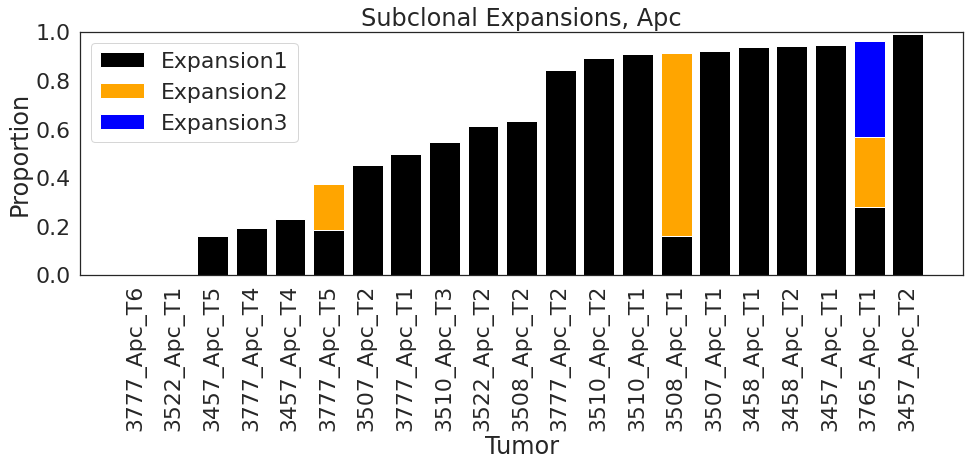

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


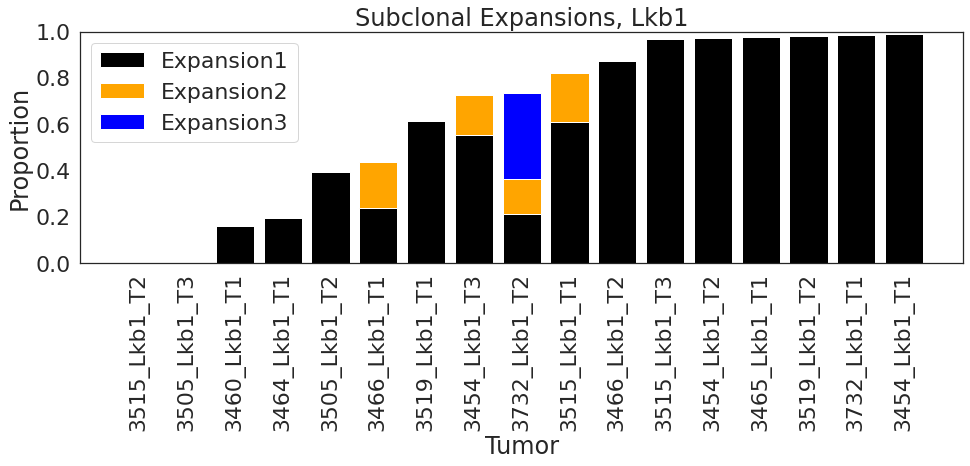

In [235]:
plot_expansions(apc_proportions, "apc_expansion_proportions.eps")

plot_expansions(lkb1_proportions, "lkb1_expansion_proportions.eps")

### Plot cluster composition for KPL and KPA Tumors - Figure S6E

In [217]:
def tree_exists(tumor):
    
    filepath = f'/data/yosef2/users/mattjones/projects/kptc/KPTracer-Data/trees/{tumor}_tree.nwk'
    return os.path.exists(filepath)

def plot_tumor_composition(adata, genotype):
    
    fitness_signatures = adata.obs.groupby("Tumor").agg({'FitnessSignature': 'mean'})

    x = adata.obs.groupby(by = ['Tumor', 'Cluster']).size() / adata.obs.groupby(by = 'Tumor').size()
    piv = x.unstack()

    piv[piv.isna()] = 0

    clust_colors = palettes.Category20[len(adata.obs['Cluster'].unique())]
    clust_color_map = colors.ListedColormap(clust_colors)

    piv = x.unstack()
    _ord = np.sort(fitness_signatures.index.values)
    _ord = [t for t in _ord if t != 'nan' and t.split("_")[2][0] == 'T' and tree_exists(t) and genotype in t and '3467_Lkb1' not in t]
    ax = piv.loc[_ord].plot(kind='bar', stacked=True, figsize = (25, 10),
                                        colormap=clust_color_map, fontsize=12)
    ax.legend(bbox_to_anchor=(1,1))
    ax.grid(False)
    plt.title(f"Tumor by Cluster, sg{genotype}")
    plt.tight_layout()
    plt.show()

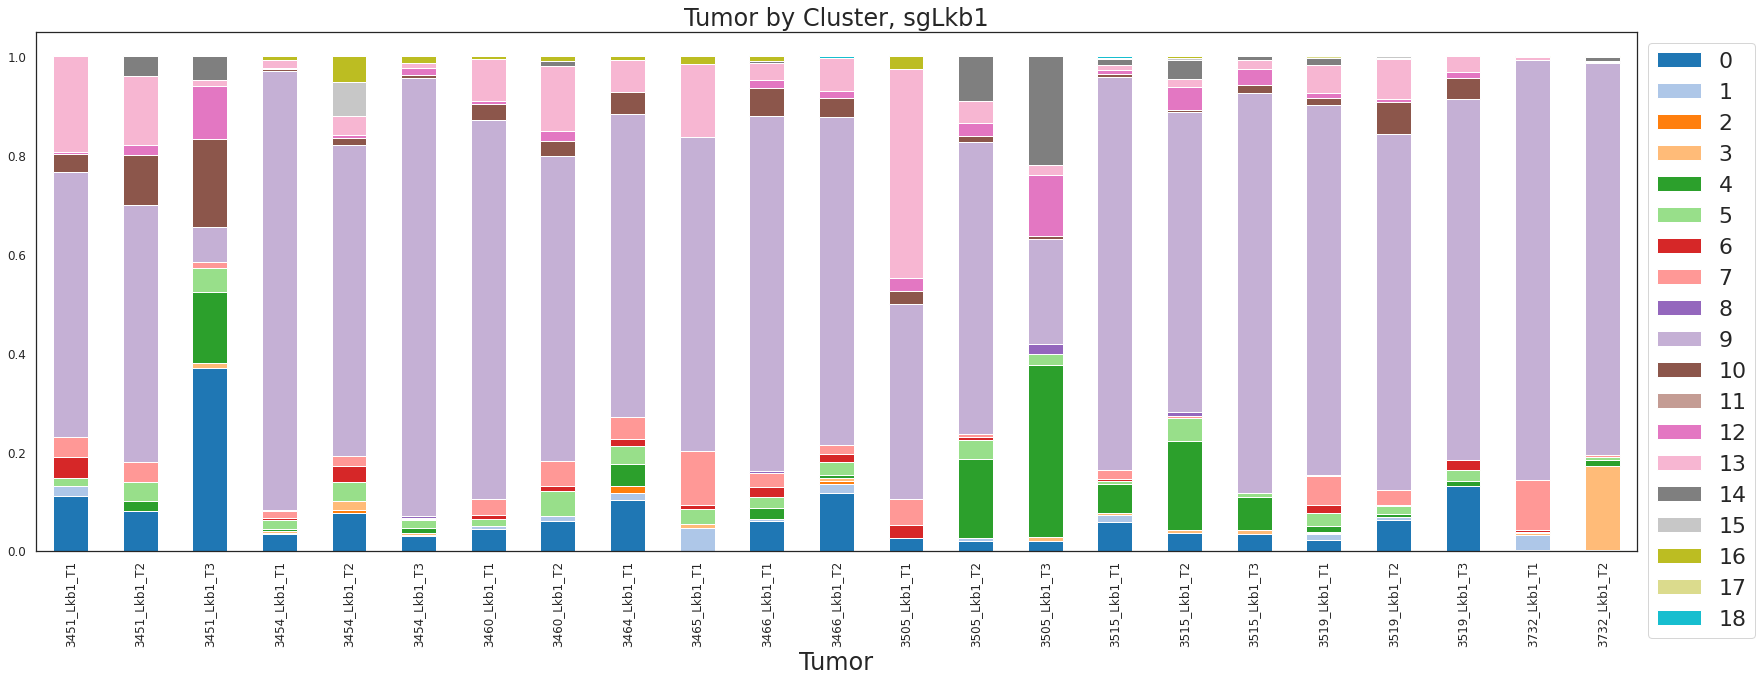

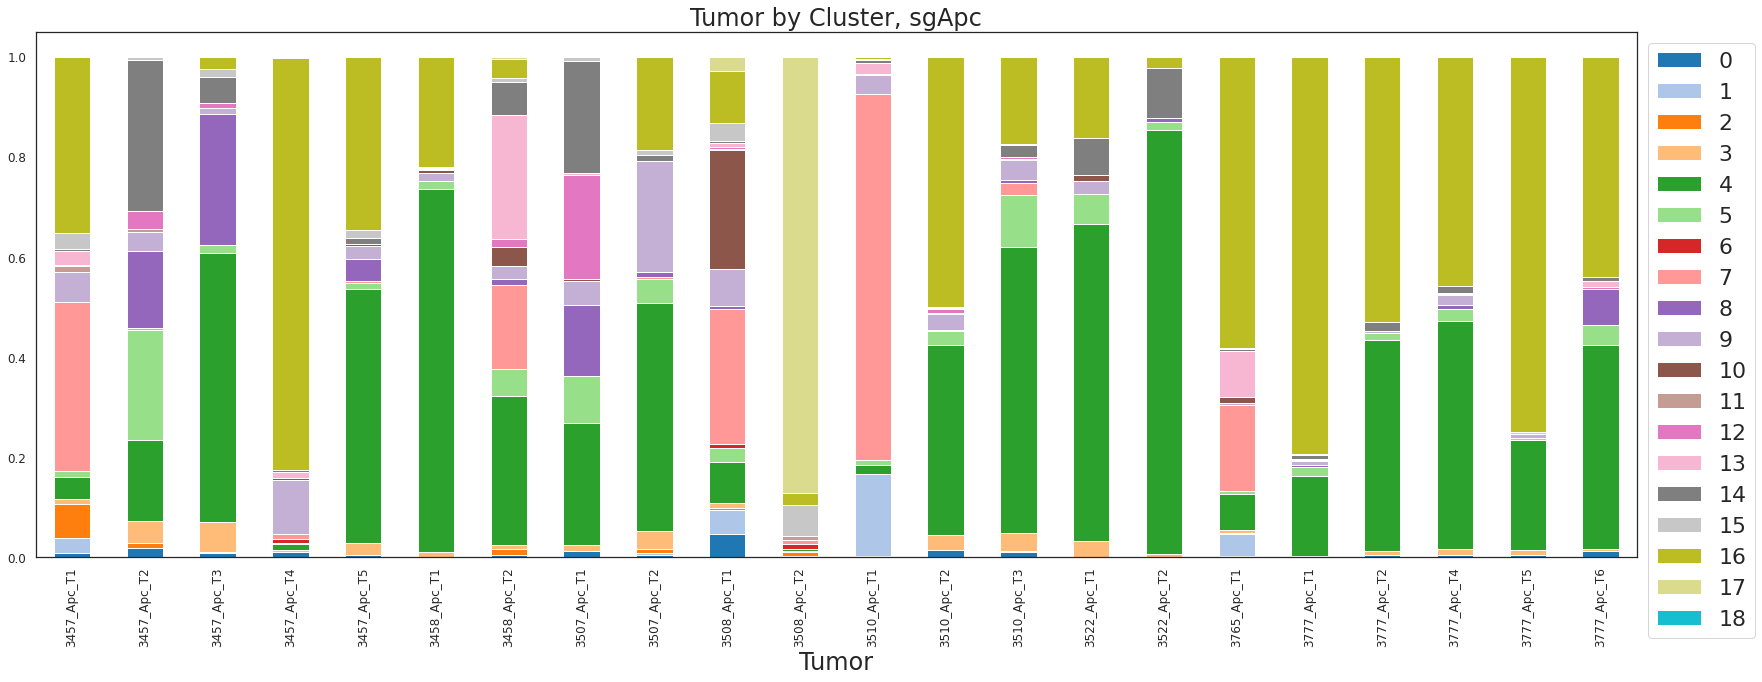

In [218]:
sigscores = pd.read_csv("./data/fitness_signature_scores.tsv", sep='\t', index_col = 0)

adata.obs['FitnessSignature'] = sigscores.loc[adata.obs_names, 'FitnessSignature_NT']

plot_tumor_composition(adata, 'Lkb1')

plot_tumor_composition(adata, 'Apc')

### Plasticity analysis of clusters by genotype - Figure 6D and S6F

In [69]:
plasticity_indices = pd.read_csv("../Figure4_S4/scripts/plasticity_scores_v2.tsv", sep='\t', index_col = 0)

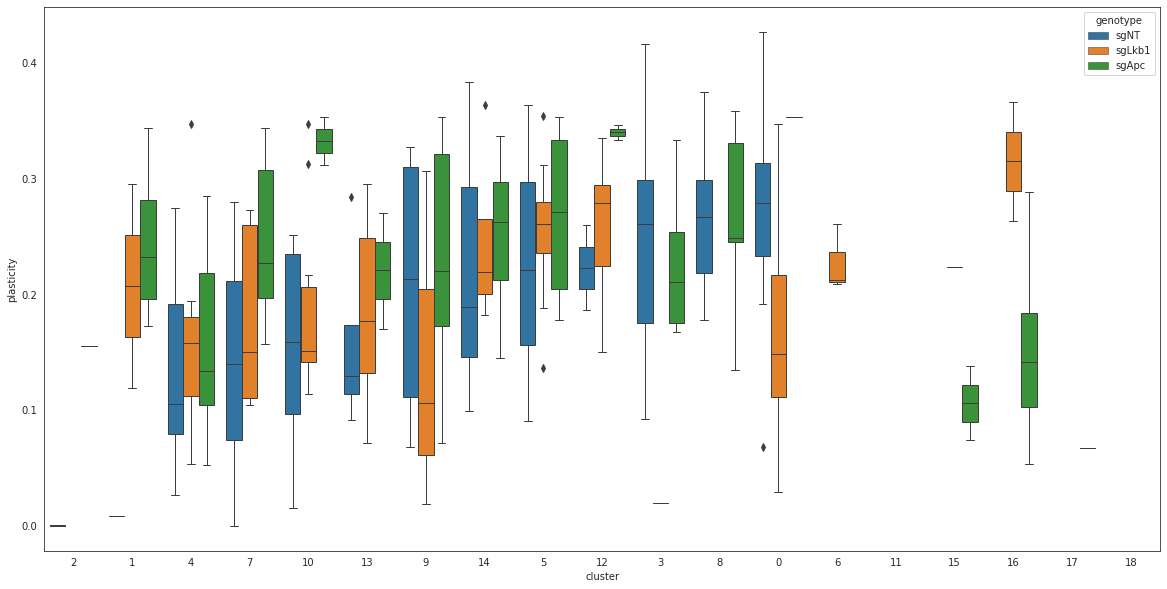

In [70]:
cluster_to_plasticities = pd.DataFrame(columns = ['cluster', 'plasticity', 'genotype', 'tumor'])
for cluster, g in adata.obs.groupby("Cluster"):
        
    indices = g.index.values
    indices = np.intersect1d(indices, plasticity_indices.index)
    vals = []
    genotypes = []
    tumors = []
    
    for tumor, g2 in g.loc[indices].groupby('Tumor'):
        if '3467' not in tumor:
            vals.append(plasticity_indices.loc[g2.index.values, 'scPlasticity'].median())
            genotypes.append(adata.obs.loc[adata.obs['Tumor'] == tumor, 'genotype'].values[0])
            tumors.append(tumor)

    # vals = plasticity.loc[indices, 'Plasticity'].values
    _df = pd.DataFrame([[int(cluster)]*len(vals), vals, genotypes, tumors], index=['cluster', 'plasticity', 'genotype', 'tumor']).T
    cluster_to_plasticities = pd.concat([cluster_to_plasticities, _df])

cluster_to_mean_plasticity = {}
for cluster, g in cluster_to_plasticities[cluster_to_plasticities['genotype'] == 'sgNT'].groupby('cluster'):
    cluster_to_mean_plasticity[cluster] = g['plasticity'].mean()
    
cluster_order = pd.DataFrame.from_dict(cluster_to_mean_plasticity, orient='index', columns = ['plasticity']).sort_values(by='plasticity', ascending=True).index


h = plt.figure(figsize=(20, 10))
sns.set_style("white")
sns.boxplot(x = 'cluster', y="plasticity", hue = 'genotype',
                    data=cluster_to_plasticities, order=cluster_order,
                    linewidth = 1)
plt.show()

KP vs KPL, cluster 9: 0.027514351165619056
KP vs KPA, cluster 9: 0.747419868454272


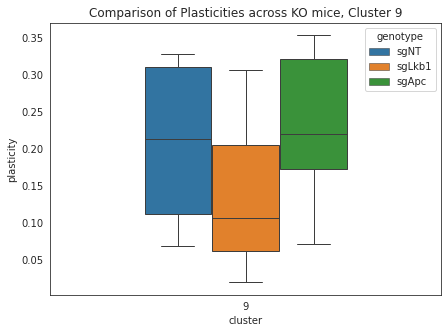

In [73]:
cluster = 9

# compute mann whitney-u statistics comparing KO mice to KP mice
cluster_plasticity = cluster_to_plasticities[cluster_to_plasticities['cluster'] == cluster]

nt_vs_lkb1 = scipy.stats.mannwhitneyu(cluster_plasticity.loc[cluster_plasticity['genotype'] == 'sgNT', 'plasticity'].dropna().values,
                  cluster_plasticity.loc[cluster_plasticity['genotype'] == 'sgLkb1', 'plasticity'].dropna().values, alternative='greater')[1]

nt_vs_apc = scipy.stats.mannwhitneyu(cluster_plasticity.loc[cluster_plasticity['genotype'] == 'sgNT', 'plasticity'].dropna().values,
                  cluster_plasticity.loc[cluster_plasticity['genotype'] == 'sgApc', 'plasticity'].dropna().values, alternative='greater')[1]

print(f'KP vs KPL, cluster {cluster}: {nt_vs_lkb1}')
print(f'KP vs KPA, cluster {cluster}: {nt_vs_apc}')


h = plt.figure(figsize=(7, 5))
sns.set_style("white")
sns.boxplot(x = 'cluster', y="plasticity", hue = 'genotype',
                    data=cluster_plasticity,
                    linewidth = 1)
plt.title(f'Comparison of Plasticities across KO mice, Cluster {cluster}')
plt.show()

## Evolutionary Coupling Analysis

These couplings were computed with the script in `KPTracer-release/reproducibility/Figure5_S5/scripts/compute_evolutionary_couplings.py`.

In [191]:
tumor_z_df_all = pd.read_csv("evolutionary_couplings.txt", sep='\t', index_col = 0)

In [192]:
NUM_CELLS_THRESH = 100

tumor_clone_statistics = pd.read_csv("/data/yosef2/users/mattjones/projects/kptc/tumor_statistics.tsv", sep='\t', index_col = 0)

unfiltered = np.intersect1d(tumor_clone_statistics[(tumor_clone_statistics['NumCells'] >= NUM_CELLS_THRESH)].index, tumor_z_df_all.index)

In [193]:
tumor_z_df_all = tumor_z_df_all.loc[unfiltered]

tmat_z = tumor_z_df_all \
    .subtract(tumor_z_df_all.mean(axis=1), axis=0) \
    .divide(tumor_z_df_all.std(axis=1), axis=0)

tmat_z = np.nan_to_num(tmat_z)

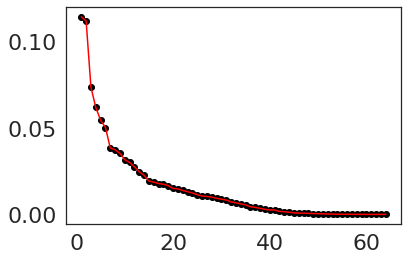

In [194]:
pca = PCA()
tmat_transformed = pca.fit_transform(tmat_z)

loadings = np.transpose(pca.components_[0:2, :])
var_explained = pca.explained_variance_ratio_

plt.scatter(np.arange(1, len(var_explained)+1), var_explained, color='black')
plt.plot(np.arange(1, len(var_explained)+1), var_explained, color='red')
plt.show()

pc1_top_loading = np.argmax(loadings[:,0])
pc2_top_loading = np.argmax(loadings[:,1])

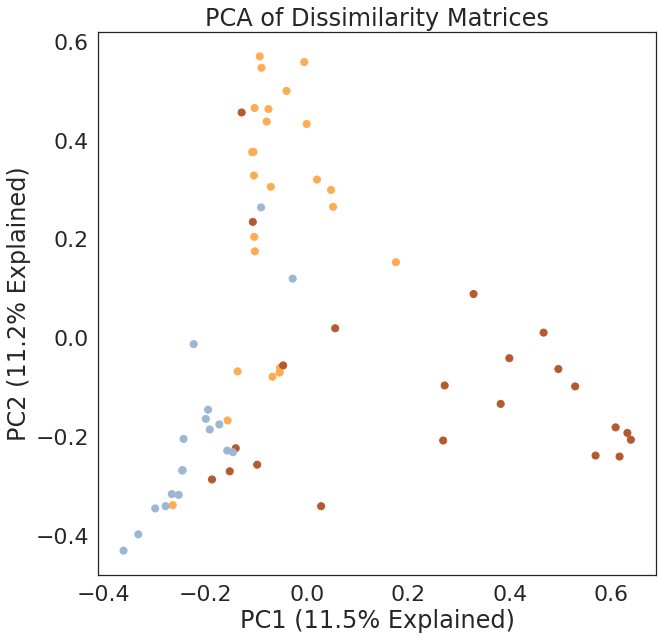

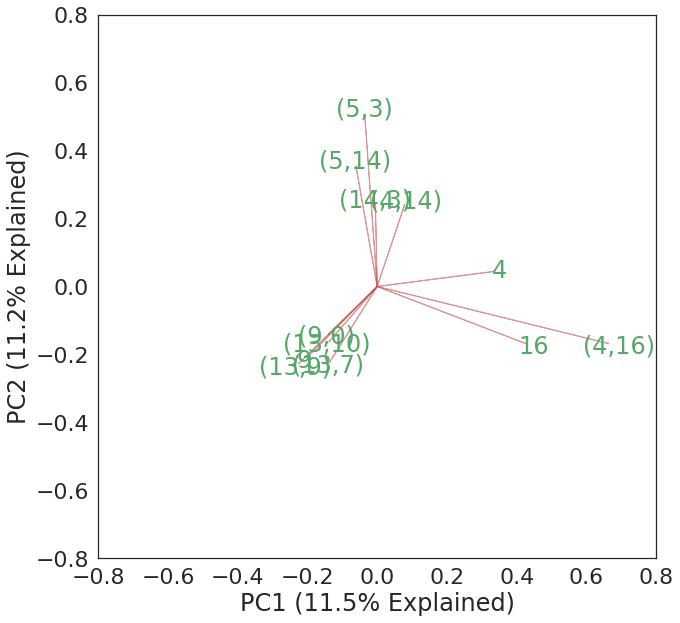

In [204]:
d1, d2 = 0,1

sns.set_style("white")
tumors = tumor_z_df_all.index

genotype_to_color = {'NT': '#fdac53',
                    'Lkb1': '#9bb7d4',
                    'Apc': '#b55a30'}

x, y = tmat_transformed[:,d1], tmat_transformed[:, d2]
sizes = dict(zip(tumor_z_df_all.index.values, x))
ss = dict(zip(tumor_z_df_all.index.values, y))
labs = tumor_z_df_all.index.values

scalex = 1.0/(x.max() - x.min())
scaley = 1.0/(y.max() - y.min())

h = plt.figure(figsize = (10, 10))
ax = plt.scatter(x*scalex, y*scaley, c=[genotype_to_color[tumor.split("_")[1]] for tumor in tumor_z_df_all.index.values], s=50)
plt.title("PCA of Dissimilarity Matrices")

plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))
plt.show()


h = plt.figure(figsize = (10, 10))
coeff = np.transpose(pca.components_)

iis = np.argsort(np.abs(coeff[:, d1]))[::-1][:7]
iis = np.unique(np.concatenate((iis, np.argsort(np.abs(coeff[:, d2]))[::-1][:7])))
for i in iis:
    plt.arrow(0, 0, coeff[i,d1], coeff[i,d2], color = 'r',alpha = 0.5)
    plt.text(coeff[i,d1]* 1.05, coeff[i,d2] * 1.05, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))

plt.show()
